In [1]:
from PIL import Image, ImageDraw, ImageFont
import numpy as np
from scipy import linalg
from IPython.display import display

In [2]:
!apt-get -y install fonts-ipafont-gothic

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-ipafont-gothic is already the newest version (00303-18ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.


In [3]:
fpath='/usr/share/fonts/opentype/ipafont-gothic/ipagp.ttf'
fontsize = 50
font = ImageFont.truetype(fpath, fontsize)

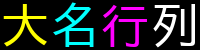

In [4]:
LX = 200
LY = fontsize
img  = Image.new('RGB', (LX,LY),color="black")
draw = ImageDraw.Draw(img)
draw.text((0,0), "大　　　", fill=(255,255,0), font=font)
draw.text((0,0), "　名　　", fill=(0,255,255), font=font)
draw.text((0,0), "　　行　", fill=(255,0,255), font=font)
draw.text((0,0), "　　　列", fill="white", font=font)
img

In [5]:
data = np.array(img.getdata()).reshape(LY,LX,3)

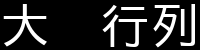

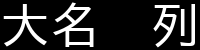

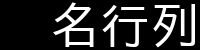

In [6]:
R = data[:,:,0]
G = data[:,:,1]
B = data[:,:,2]
display(Image.fromarray(np.uint8(R)))
display(Image.fromarray(np.uint8(G)))
display(Image.fromarray(np.uint8(B)))

In [7]:
def perform_svd(X, rank):
  U, s, V = linalg.svd(X)
  Ur = U[:, :rank]
  Sr = np.diag(np.sqrt(s[:rank]))
  Vr = V[:rank, :]
  A = Ur @ Sr
  B = Sr @ Vr
  return A, B

In [8]:
def simple_image(X, rank):
  X = data.reshape((200,150))
  A, B = perform_svd(X, rank)
  Y = (A @ B).reshape(LY,LX,3)
  Y = np.clip(Y, 0, 255)
  Y = np.uint8(Y)
  print((A.size+B.size)/X.size)
  return Image.fromarray(Y)

0.5833333333333334


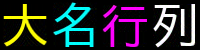

0.245


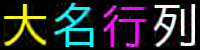

0.09333333333333334


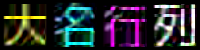

In [9]:
display(simple_image(data, 50))
display(simple_image(data, 21))
display(simple_image(data, 8))

In [10]:
def rgb_svd(X, rank):
  R = X[:,:,0]
  G = X[:,:,1]
  B = X[:,:,2]
  Rh, Rw = perform_svd(R, rank)
  Gh, Gw = perform_svd(G, rank)
  Bh, Bw = perform_svd(B, rank)
  return Rh, Rw, Gh, Gw, Bh, Bw

In [11]:
def rgb_image(X, rank):
  Rh, Rw, Gh, Gw, Bh, Bw = rgb_svd(X, rank)
  R = Rh @ Rw
  G = Gh @ Gw
  B = Bh @ Bw
  Y = np.asarray([R,G,B]).transpose(1,2,0)
  Y = np.clip(Y, 0, 255)
  Y = np.uint8(Y)
  print((Rh.size+Rw.size)*3/X.size)
  return Image.fromarray(Y)

1.25


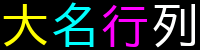

0.25


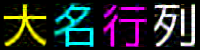

0.1


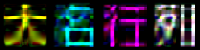

In [12]:
display(rgb_image(data, 50))
display(rgb_image(data, 10))
display(rgb_image(data, 4))

In [13]:
def tucker_decomposition(X, rank):
  X = X.transpose(0,2,1)
  XR = X.reshape(LY*3, LX)
  _, _, V = linalg.svd(XR)
  V = V[:rank,:]
  Vt = V.transpose(1,0)
  XL = X.reshape(LY, LX*3)
  U, _, _ = linalg.svd(XL)
  U = U[:,:rank]
  Ut = U.transpose(1,0)
  # Make a core tensor
  UX = np.tensordot(Ut, X, (1,0))
  C = np.tensordot(UX, Vt, (2, 0))
  return U, C, V

In [14]:
def tucker_image(X, rank):
  U, C, V = tucker_decomposition(X, rank)
  UC = np.tensordot(U,C,(1,0))
  Y = np.tensordot(UC, V, (2,0))
  Y = Y.transpose((0,2,1))
  Y = np.clip(Y, 0, 255)
  Y = np.uint8(Y)
  print((U.size+C.size+V.size)/X.size)
  return Image.fromarray(Y)

0.6666666666666666


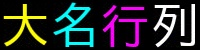

0.24456666666666665


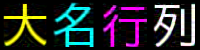

0.09333333333333334


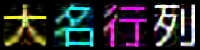

In [15]:
display(tucker_image(data, 50))
display(tucker_image(data, 23))
display(tucker_image(data, 10))